In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path
import re

# ============================================================
# CONFIG
# ============================================================
DATA_ROOT = Path("/mnt/hdd/ttoxopeus/datasets/nnUNet_raw/Dataset300_MM")

IMAGES_DIR = DATA_ROOT / "imagesTs"
LABELS_DIR = DATA_ROOT / "labelsTs"

PHASE_ED = "ED"
PHASE_ES = "ES"

DISPLAY_TIME_SEC = 0.5   # how long each patient is shown (seconds)

# ============================================================
# DISCOVER PATIENT IDS
# ============================================================
def get_patient_ids(images_dir: Path):
    """
    Extract patient IDs from filenames like:
      patient101_ED_0000.nii.gz
    """
    ids = set()
    pattern = re.compile(r"patient(\d+)_")
    for p in images_dir.glob("patient*_*.nii.gz"):
        m = pattern.search(p.name)
        if m:
            ids.add(int(m.group(1)))
    return sorted(ids)


patient_ids = get_patient_ids(IMAGES_DIR)
print(f"Found {len(patient_ids)} patients")

# ============================================================
# LOOP & VISUALIZE
# ============================================================
plt.ion()  # interactive mode ON

for pid in patient_ids:
    try:
        img_ed = nib.load(IMAGES_DIR / f"patient{pid}_{PHASE_ED}_0000.nii.gz").get_fdata()
        img_es = nib.load(IMAGES_DIR / f"patient{pid}_{PHASE_ES}_0000.nii.gz").get_fdata()

        gt_ed = nib.load(LABELS_DIR / f"patient{pid}_{PHASE_ED}.nii.gz").get_fdata()
        gt_es = nib.load(LABELS_DIR / f"patient{pid}_{PHASE_ES}.nii.gz").get_fdata()
    except FileNotFoundError as e:
        print(f"[SKIP] patient{pid}: missing file")
        continue

    z = img_ed.shape[2] // 2  # mid slice

    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    fig.suptitle(f"patient{pid} – ED vs ES", fontsize=14)

    axs[0, 0].imshow(img_ed[:, :, z], cmap="gray")
    axs[0, 0].set_title("ED image")

    axs[0, 1].imshow(img_es[:, :, z], cmap="gray")
    axs[0, 1].set_title("ES image")

    axs[1, 0].imshow(img_ed[:, :, z], cmap="gray")
    axs[1, 0].imshow(gt_ed[:, :, z], alpha=0.5)
    axs[1, 0].set_title("ED + label")

    axs[1, 1].imshow(img_es[:, :, z], cmap="gray")
    axs[1, 1].imshow(gt_es[:, :, z], alpha=0.5)
    axs[1, 1].set_title("ES + label")

    for ax in axs.ravel():
        ax.axis("off")

    plt.tight_layout()
    plt.show()

    plt.pause(DISPLAY_TIME_SEC)
    plt.close(fig)

plt.ioff()
print("Done.")


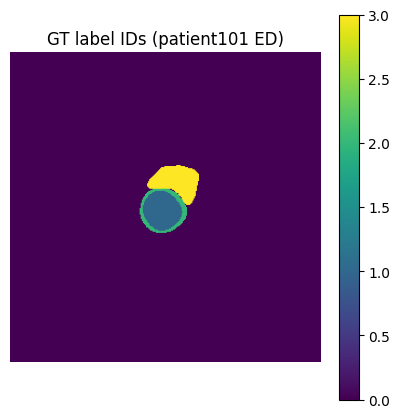

1 6266
2 2893
3 6006


In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

DATA_ROOT = Path("/mnt/hdd/ttoxopeus/datasets/nnUNet_raw/Dataset300_MM")
LABELS_DIR = DATA_ROOT / "labelsTs"

pid = 101
phase = "ED"
gt = nib.load(LABELS_DIR / f"patient{pid}_{phase}.nii.gz").get_fdata()
z = gt.shape[2] // 2

plt.figure(figsize=(5,5))
plt.imshow(gt[:, :, z], vmin=0, vmax=3)
plt.title(f"GT label IDs (patient{pid} {phase})")
plt.colorbar()
plt.axis("off")
plt.show()

# Print rough sizes per label
for k in [1,2,3]:
    print(k, int(np.sum(gt == k)))


In [2]:
import nibabel as nib
import numpy as np
from pathlib import Path
import shutil

# ============================================================
# CONFIG
# ============================================================
DATA_ROOT = Path("/mnt/hdd/ttoxopeus/datasets/nnUNet_raw/Dataset300_MM")
LABELS_DIR = DATA_ROOT / "labelsTs"

MAKE_BACKUP = True   # strongly recommended the first time
BACKUP_DIR = DATA_ROOT / "labelsTs_backup"

# ============================================================
# LABEL REMAP
# ============================================================
def remap_labels(seg: np.ndarray) -> np.ndarray:
    """
    Swap label 1 <-> 3, keep others unchanged.
    """
    out = seg.copy()
    out[seg == 1] = 99   # temp label
    out[seg == 3] = 1
    out[out == 99] = 3
    return out


# ============================================================
# MAIN
# ============================================================
if MAKE_BACKUP:
    if not BACKUP_DIR.exists():
        print(f"Creating backup in {BACKUP_DIR}")
        shutil.copytree(LABELS_DIR, BACKUP_DIR)
    else:
        print(f"Backup already exists at {BACKUP_DIR}")

label_files = sorted(LABELS_DIR.glob("patient*_*.nii.gz"))
print(f"Found {len(label_files)} label files")

for p in label_files:
    nii = nib.load(p)
    seg = nii.get_fdata()

    # Round & cast (labels should be ints)
    seg = np.rint(seg).astype(np.uint8)

    unique_before = set(np.unique(seg).tolist())

    seg_new = remap_labels(seg)
    unique_after = set(np.unique(seg_new).tolist())

    nib.save(
        nib.Nifti1Image(seg_new, affine=nii.affine, header=nii.header),
        p
    )

    print(
        f"[OK] {p.name}: {sorted(unique_before)} -> {sorted(unique_after)}"
    )

print("Done remapping labels.")


Creating backup in /mnt/hdd/ttoxopeus/datasets/nnUNet_raw/Dataset300_MM/labelsTs_backup
Found 68 label files
[OK] patient101_ED.nii.gz: [0, 1, 2, 3] -> [0, 1, 2, 3]
[OK] patient101_ES.nii.gz: [0, 1, 2, 3] -> [0, 1, 2, 3]
[OK] patient102_ED.nii.gz: [0, 1, 2, 3] -> [0, 1, 2, 3]
[OK] patient102_ES.nii.gz: [0, 1, 2, 3] -> [0, 1, 2, 3]
[OK] patient103_ED.nii.gz: [0, 1, 2, 3] -> [0, 1, 2, 3]
[OK] patient103_ES.nii.gz: [0, 1, 2, 3] -> [0, 1, 2, 3]
[OK] patient104_ED.nii.gz: [0, 1, 2, 3] -> [0, 1, 2, 3]
[OK] patient104_ES.nii.gz: [0, 1, 2, 3] -> [0, 1, 2, 3]
[OK] patient105_ED.nii.gz: [0, 1, 2, 3] -> [0, 1, 2, 3]
[OK] patient105_ES.nii.gz: [0, 1, 2, 3] -> [0, 1, 2, 3]
[OK] patient106_ED.nii.gz: [0, 1, 2, 3] -> [0, 1, 2, 3]
[OK] patient106_ES.nii.gz: [0, 1, 2, 3] -> [0, 1, 2, 3]
[OK] patient107_ED.nii.gz: [0, 1, 2, 3] -> [0, 1, 2, 3]
[OK] patient107_ES.nii.gz: [0, 1, 2, 3] -> [0, 1, 2, 3]
[OK] patient108_ED.nii.gz: [0, 1, 2, 3] -> [0, 1, 2, 3]
[OK] patient108_ES.nii.gz: [0, 1, 2, 3] -> [0, 1, 2